In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.signal
import pandas as pd
from types import SimpleNamespace

# !pip install pint
from pint import UnitRegistry
units = UnitRegistry(system = "mks")
units.default_format = "~P.2e"

/home/rajiv/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Solenoid value (0-255)
0.0      509.980000
1.0      509.990000
2.0      509.990000
3.0      509.990000
4.0      509.990000
5.0      509.970000
6.0      509.960000
7.0      509.990000
8.0      510.050000
9.0      510.030000
10.0     510.050000
11.0     510.030000
12.0     510.060000
13.0     510.080000
14.0     510.090000
15.0     510.120000
16.0     510.090909
17.0     510.130000
18.0     510.160000
19.0     510.220000
20.0     510.224490
21.0     510.160000
22.0     510.210000
23.0     510.282828
24.0     510.282828
25.0     510.320000
26.0     510.340000
27.0     510.390000
28.0     510.370000
29.0     510.382716
30.0     510.512500
31.0     510.475000
32.0     510.531646
33.0     510.575000
34.0     510.650000
35.0     510.625000
36.0     510.625000
37.0     510.637500
38.0     510.775000
39.0     510.787500
40.0     510.775000
41.0     510.837500
42.0     510.837500
43.0     510.987500
44.0     510.925000
45.0     510.987500
46.0     511.179487
47.0     511.187500
48.0     511.1500

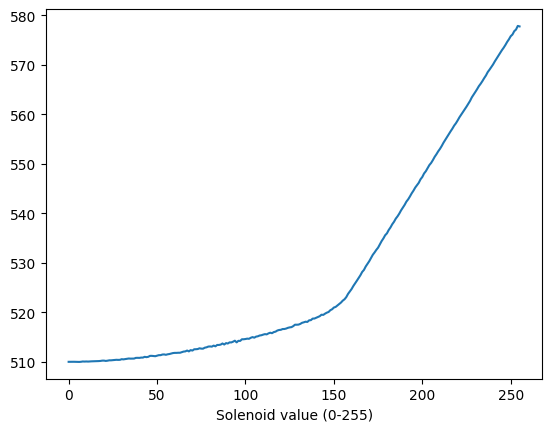

In [6]:
sensor_data = pd.read_csv("step_ramp_1sSteps.csv")
# sensor_data = sensor_data.truncate(before=400, after=5550)
sensor_data.drop(sensor_data.columns[3], axis=1, inplace=True)

# Drop rows with NaN values in "solenoid_commanded" column
df_short_solenoid = sensor_data['Solenoid value (0-255)'].dropna()
# Drop rows with NaN values in "analog value (1-1024) (raw)" column
df_short_analog = sensor_data['Hall analog (raw)'].dropna()
df_short_analog.index = df_short_solenoid.index
# Merge the shortened DataFrames based on the index
df_shortened = pd.concat([df_short_solenoid, df_short_analog],axis=1)

# Group by "solenoid_commanded" and calculate the average of "analog value (1-1024) (raw)"
average_values = df_shortened.groupby('Solenoid value (0-255)')['Hall analog (raw)'].mean()
average_values.plot()
# sensor_data.drop(sensor_data.columns[0], axis=1, inplace=True)

# if interpolating
# sensor_data = sensor_data.interpolate()

# if droppi"analog value (1-1024) (raw)"ng na values and collapsing
# sensor_data["analog value (1-1024) (raw)"] = sensor_data["analog value (1-1024) (raw)"][sensor_data["analog value (1-1024) (raw)"].notna()]
# sensor_data["solenoid_commanded"] = sensor_data["solenoid_commanded"][sensor_data["solenoid_commanded"].notna()]

# mean_window = 50
# sensor_data["analog average"] = sensor_data["analog value (1-1024) (raw)"].rolling(mean_window).mean().shift(-mean_window//2)
# sensor_data.dropna(inplace = True)

# sensor_data.plot()
# sensor_data.plot(x="solenoid_commanded", y="analog value (1-1024) (raw)")
# sensor_data.plot(x="solenoid_commanded", y="analog average")
pd.options.display.max_rows = 4000
print(average_values)

Linear regression between 155 and 255: slope = 0.5806, intercept = 432
Linear regression between 50 and 155: slope = 0.0952, intercept = 505


Text(0, 0.5, 'Hall effect sensor reading (0-1023)')

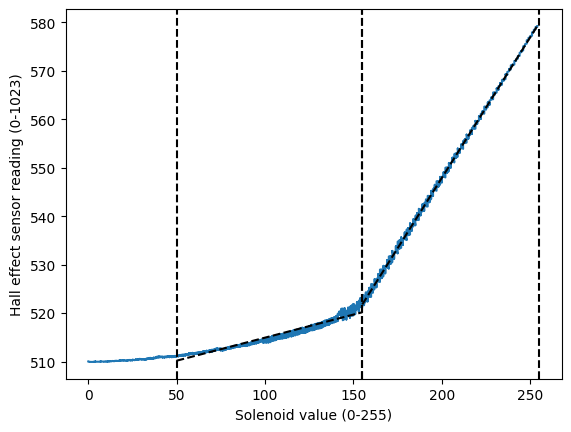

In [48]:
class LinearRegressionRegion():
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.range = (self.start <= sensor_data["solenoid_commanded"]) & (sensor_data["solenoid_commanded"] <= self.end) & sensor_data["solenoid_commanded"].notnull()

        # linear regression
        A = np.vstack([sensor_data["solenoid_commanded"][self.range], np.ones(len(sensor_data["solenoid_commanded"][self.range]))]).T
        self.slope, self.intercept = np.linalg.lstsq(A, sensor_data["analog average"][self.range], rcond=None)[0]
        self.print_values()

    def plot(self):
        plt.axvline(x = self.start, color = "black", linestyle = "dashed")
        plt.axvline(x = self.end, color = "black", linestyle = "dashed")
        plt.plot(sensor_data["solenoid_commanded"][self.range], sensor_data["solenoid_commanded"][self.range] * self.slope + self.intercept, color = "black", linestyle = "dashed")

    def print_values(self):
        print(f"Linear regression between {self.start} and {self.end}: slope = {self.slope:.4f}, intercept = {self.intercept:.0f}")

plt.plot(sensor_data["solenoid_commanded"], sensor_data["analog average"])
region_1 = LinearRegressionRegion(start = 155, end = 255)
region_1.plot()
region_2 = LinearRegressionRegion(start = 50, end = 155)
region_2.plot()
plt.xlabel("Solenoid value (0-255)")
plt.ylabel("Hall effect sensor reading (0-1023)")